In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
# 📁 Load & Clean Data
df = pd.read_csv("../data/FootballPlayerRawDataset.csv")
df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()
df.drop_duplicates(inplace=True)

In [3]:
# 🔧 Currency conversion
def parse_currency(value):
    if isinstance(value, str):
        value = value.replace('€', '').replace('M', 'e6').replace('K', 'e3')
        try:
            return float(eval(value))
        except:
            return np.nan
    return value

df['value'] = df['value'].apply(parse_currency)
df['wage'] = df['wage'].apply(parse_currency)

In [4]:
# 📐 Convert height/weight
def height_to_cm(height):
    try:
        feet, inches = height.split("'")
        return round((int(feet) * 12 + int(inches.replace('\"', ''))) * 2.54)
    except:
        return np.nan

def weight_to_kg(weight):
    try:
        return round(int(weight.replace('lbs', '')) * 0.453592)
    except:
        return np.nan

df['height_cm'] = df['height'].apply(height_to_cm)
df['weight_kg'] = df['weight'].apply(weight_to_kg)


In [5]:
# Drop unused columns
df.drop(columns=['height', 'weight'], inplace=True)

In [6]:
# One-hot encode position if available
if 'position' in df.columns:
    df = pd.get_dummies(df, columns=['position'], drop_first=True)

In [7]:
# ✅ Feature Selection
selected_features = [
    'overall', 'potential', 'wage', 'international_reputation',
    'skill_moves', 'weak_foot', 'age', 'height_cm', 'weight_kg'
] + [col for col in df.columns if col.startswith('position_')]

df_model = df[['name', 'value'] + selected_features].dropna()
X = df_model[selected_features]
y = np.log1p(df_model['value'])  # log(1 + value)
names = df_model['name']


In [8]:
# ✂️ Train-Test Split
X_train, X_test, y_train, y_test, names_train, names_test = train_test_split(
    X, y, names, test_size=0.2, random_state=42
)

In [9]:
# 🧠 Train XGBoost Model
model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [10]:
# 🎯 Evaluation
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"✅ MAE: €{mae:,.0f}")
print(f"✅ RMSE: €{rmse:,.0f}")
print(f"✅ R² Score: {r2:.4f}")

✅ MAE: €121,934
✅ RMSE: €576,539
✅ R² Score: 0.9891


In [11]:
# 🔁 Cross-validation (optional)
scores = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
print("CV Avg RMSE:", -np.mean(scores))

CV Avg RMSE: 0.569925202325664


In [12]:
# 📊 Visualizations
sns.set(style="whitegrid")

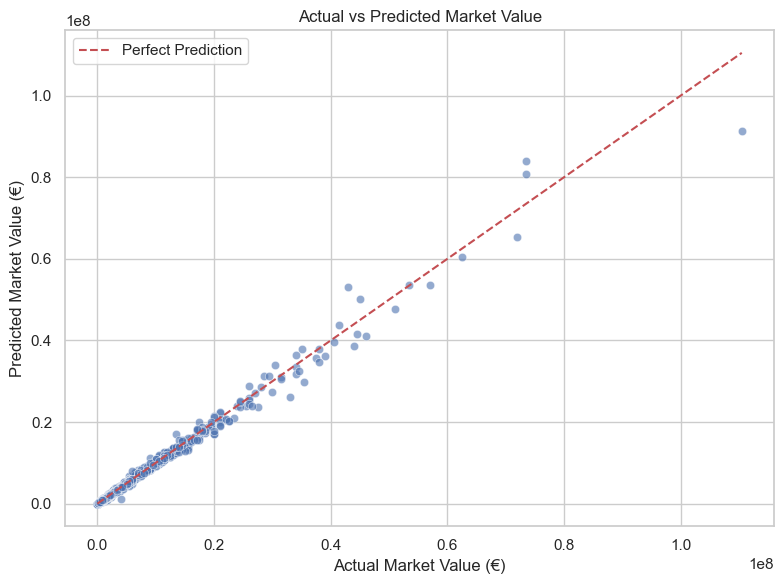

In [13]:
# 1️⃣ Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label="Perfect Prediction")
plt.xlabel("Actual Market Value (€)")
plt.ylabel("Predicted Market Value (€)")
plt.title("Actual vs Predicted Market Value")
plt.legend()
plt.tight_layout()
plt.show()

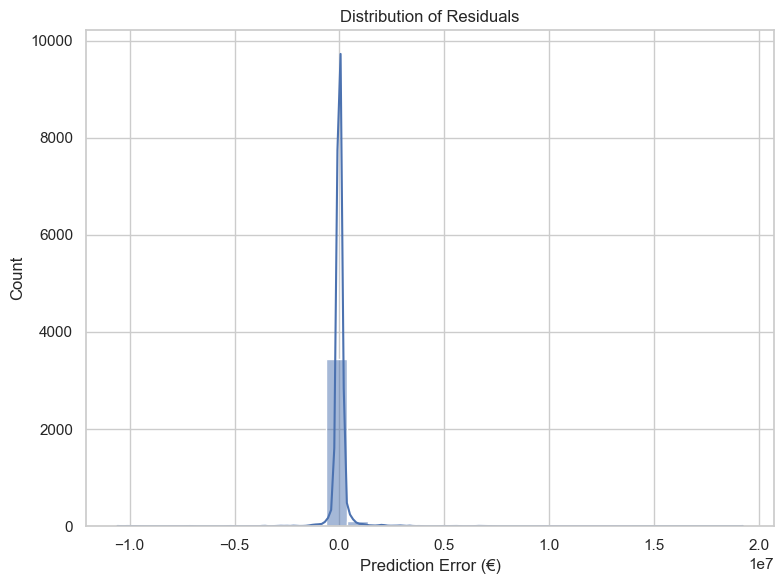

In [14]:
# 2️⃣ Residual Distribution
residuals = y_true - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Distribution of Residuals")
plt.xlabel("Prediction Error (€)")
plt.tight_layout()
plt.show()

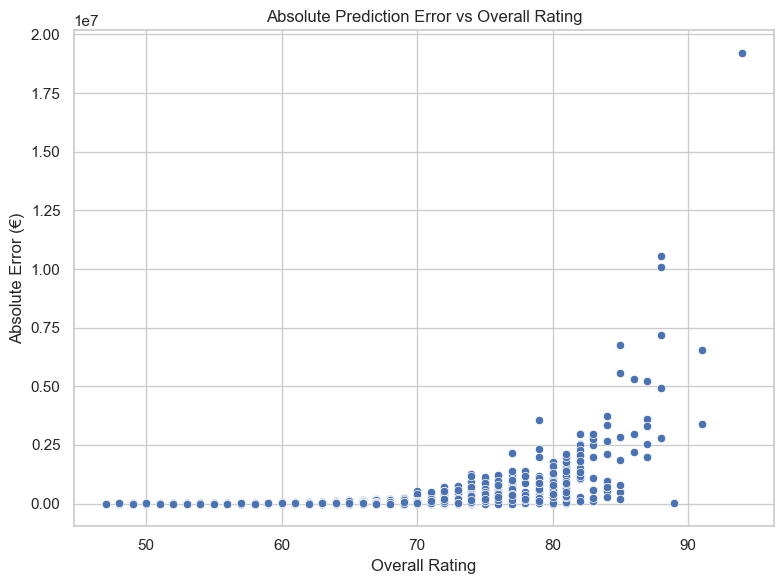

In [15]:
# 3️⃣ Absolute Error vs Overall
if 'overall' in X_test.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_test['overall'], y=abs(residuals))
    plt.title("Absolute Prediction Error vs Overall Rating")
    plt.xlabel("Overall Rating")
    plt.ylabel("Absolute Error (€)")
    plt.tight_layout()
    plt.show()

In [17]:

# Save the trained model
joblib.dump(model, "../xgboost_model.pkl")  # You can change the path as needed

print("✅ Model saved as xgboost_model.pkl")

✅ Model saved as xgboost_model.pkl
